# SVG 直方图

演示如何创建交互式直方图，其中通过点击图例标记来隐藏或显示条形。

交互性在 ecmascript（javascript）中编码，并在后处理步骤中插入到 SVG 代码中。要渲染图像，请在网络浏览器中打开它。大部分 Linux 和 macOS 用户使用的网络浏览器都支持 SVG。Windows IE9 支持 SVG，但早期版本不支持。

## 注意事项
Matplotlib 后端允许我们为每个对象分配 id。这是这里使用的机制，用于将用 python 创建的 matplotlib 对象与第二步中解析的相应 SVG 结构相关联。尽管灵活，但对于大量对象的集合来说，id 使用起来很繁琐。可以使用两种机制简化操作：

* 系统地将对象分组到 SVG `<g>` 标签中，
* 根据其来源为每个 SVG 对象分配类="hist_##" 属性。

例如，与其修改每个单独条形的属性，不如将 {func}`~matplotlib.pyplot.hist` 函数中的条形分组在一个 PatchCollection 中，或者为其分配 `class="hist_##"` 属性。

CSS 也可以更广泛地用来替换生成的 SVG 中反复出现的标记。

作者: david.huard@gmail.com

In [6]:
from pathlib import Path

Path(".temp").mkdir(parents=True, exist_ok=True)

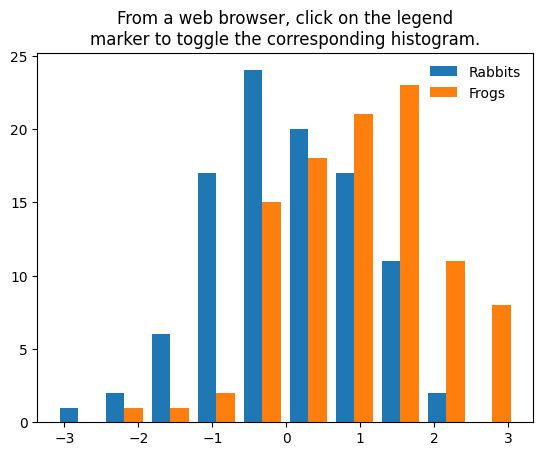

In [3]:
from io import BytesIO
import json
import xml.etree.ElementTree as ET

import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['svg.fonttype'] = 'none'

# Apparently, this `register_namespace` method is necessary to avoid garbling
# the XML namespace with ns0.
ET.register_namespace("", "http://www.w3.org/2000/svg")

# Fixing random state for reproducibility
np.random.seed(19680801)

# --- Create histogram, legend and title ---
plt.figure()
r = np.random.randn(100)
r1 = r + 1
labels = ['Rabbits', 'Frogs']
H = plt.hist([r, r1], label=labels)
containers = H[-1]
leg = plt.legend(frameon=False)
plt.title("From a web browser, click on the legend\n"
          "marker to toggle the corresponding histogram.")


# --- Add ids to the svg objects we'll modify

hist_patches = {}
for ic, c in enumerate(containers):
    hist_patches[f'hist_{ic}'] = []
    for il, element in enumerate(c):
        element.set_gid(f'hist_{ic}_patch_{il}')
        hist_patches[f'hist_{ic}'].append(f'hist_{ic}_patch_{il}')

# Set ids for the legend patches
for i, t in enumerate(leg.get_patches()):
    t.set_gid(f'leg_patch_{i}')

# Set ids for the text patches
for i, t in enumerate(leg.get_texts()):
    t.set_gid(f'leg_text_{i}')

# Save SVG in a fake file object.
f = BytesIO()
plt.savefig(f, format="svg")

# Create XML tree from the SVG file.
tree, xmlid = ET.XMLID(f.getvalue())


# --- Add interactivity ---

# Add attributes to the patch objects.
for i, t in enumerate(leg.get_patches()):
    el = xmlid[f'leg_patch_{i}']
    el.set('cursor', 'pointer')
    el.set('onclick', "toggle_hist(this)")

# Add attributes to the text objects.
for i, t in enumerate(leg.get_texts()):
    el = xmlid[f'leg_text_{i}']
    el.set('cursor', 'pointer')
    el.set('onclick', "toggle_hist(this)")

# Create script defining the function `toggle_hist`.
# We create a global variable `container` that stores the patches id
# belonging to each histogram. Then a function "toggle_element" sets the
# visibility attribute of all patches of each histogram and the opacity
# of the marker itself.

script = """
<script type="text/ecmascript">
<![CDATA[
var container = %s

function toggle(oid, attribute, values) {
    /* Toggle the style attribute of an object between two values.

    Parameters
    ----------
    oid : str
      Object identifier.
    attribute : str
      Name of style attribute.
    values : [on state, off state]
      The two values that are switched between.
    */
    var obj = document.getElementById(oid);
    var a = obj.style[attribute];

    a = (a == values[0] || a == "") ? values[1] : values[0];
    obj.style[attribute] = a;
    }

function toggle_hist(obj) {

    var num = obj.id.slice(-1);

    toggle('leg_patch_' + num, 'opacity', [1, 0.3]);
    toggle('leg_text_' + num, 'opacity', [1, 0.5]);

    var names = container['hist_'+num]

    for (var i=0; i < names.length; i++) {
        toggle(names[i], 'opacity', [1, 0])
    };
    }
]]>
</script>
""" % json.dumps(hist_patches)

# Add a transition effect
css = tree.find('.//{http://www.w3.org/2000/svg}style')
css.text = css.text + "g {-webkit-transition:opacity 0.4s ease-out;" + \
    "-moz-transition:opacity 0.4s ease-out;}"

# Insert the script and save to file.
tree.insert(0, ET.XML(script))

ET.ElementTree(tree).write(".temp/svg_histogram.svg")